# <center> Implementação Computacional Teste:
## <center> Penalty-Based Nonlinear Solver for Optimal Reactive Power Dispatch With Discrete Controls
### <center> Edilaine Martins Soler, Eduardo N. Asada, Member, IEEE, and Geraldo R. M. da Costa, Member, IEEE

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandapower as pp
from pandapower.networks import case14, case_ieee30, case118, case300, case4gs
from gekko import GEKKO
from pandapower.plotting.plotly import pf_res_plotly
import pandapower.plotting as pplot

# Dados do Sistema IEEE 14

In [179]:
from msc_rafael_pavan import otimizacao_pso_discreto_sengi
from msc_rafael_pavan import inicializa_sep
from msc_rafael_pavan import matriz_condutancia
from msc_rafael_pavan import coleta_dados_vbus
from msc_rafael_pavan import coleta_dados_gen
from msc_rafael_pavan import func_objetivo
from msc_rafael_pavan import pen_tensao
from msc_rafael_pavan import pen_ger_reativo
from msc_rafael_pavan import coleta_dados_trafo
from msc_rafael_pavan import pen_trafo
from msc_rafael_pavan import coleta_dados_bshunt
from msc_rafael_pavan import converte_trafo
from msc_rafael_pavan import cria_alcateia
from msc_rafael_pavan import cria_enxame
from msc_rafael_pavan import pen_bshunt
from msc_rafael_pavan import fluxo_de_pot
from msc_rafael_pavan import fitness
from msc_rafael_pavan import validacao
from msc_rafael_pavan import validacao_q
from msc_rafael_pavan import fluxo_de_pot_q

from msc_rafael_pavan import otimizacao_gwo_continuo
from msc_rafael_pavan import otimizacao_pso_continuo
from msc_rafael_pavan import discreto_bshunt
from msc_rafael_pavan import discreto_tap
from msc_rafael_pavan import otimizacao_gwo_discreto
from msc_rafael_pavan import otimizacao_pso_discreto
from msc_rafael_pavan import ipm_ieee30
from msc_rafael_pavan import ipm_ieee14
from msc_rafael_pavan import cria_enxame_v


sep14 = case14()
sep118 = case118()
sep30 = case_ieee30()
sep300 = case300
v_init30 = inicializa_sep(sep30,algorithm='nr', relatorio=False)
v_init14 = inicializa_sep(sep14,algorithm='nr', relatorio=False)

v_init118 = inicializa_sep(sep118,algorithm='nr', relatorio=False)


In [213]:

# sep14 = case118()


# # # # # pp.create_gen(sep14, 68, 516.4, vm_pu=1.035, sn_mva=np.nan, name=None, index=None, max_q_mvar=300, min_q_mvar=-300, min_p_mw=0, max_p_mw=815.2, scaling=1.0, type=None, slack=False, controllable=np.nan, vn_kv=np.nan, xdss_pu=np.nan, rdss_pu=np.nan, cos_phi=np.nan, in_service=True)

# inicializa_sep(sep14, algorithm='nr')

# pp.runpp(sep14)

sep14.res_line = sep14.res_line.sort_index()
sep14.line = sep14.line.sort_index()
origem = sep14.line[['from_bus']].values
destino = sep14.line[['to_bus']].values



In [214]:
    ########################################################################### Vetores de condutância e susceptância série

    m_z = np.zeros((5,len(sep14.line)))

    gkm = np.zeros(len(sep14.line))

    bkm = np.zeros(len(sep14.line))

    bo = np.zeros(len(sep14.line))

    bd = np.zeros(len(sep14.line))

    sep14.line = sep14.line.sort_index()

    sep14.bus = sep14.bus.sort_index()

    vbus = sep14.bus.vn_kv.to_numpy(dtype=np.float64)

    zbase = np.power(np.multiply(vbus,1000), 2)/(100*1e6)

    m_z[0,:] = sep14.line.from_bus.to_numpy()

    m_z[1,:] = sep14.line.to_bus.to_numpy()

    bsh = 1e-9*(2*np.pi*60*sep14.line.c_nf_per_km.to_numpy())

    m_z[4,:] = bsh


    for i in range(len(sep14.line.index.ravel())):    

        m_z[2,i] = sep14.line.r_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[3,i] = sep14.line.x_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[4,i] =  m_z[4,i] * zbase[int(m_z[0,i])]


    gkm = np.array(np.divide(m_z[2,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))

    bo = m_z[0,:]

    bd = m_z[1,:]

    ########################################################################### Vetor de susceptância

    bkm = np.array(np.divide(m_z[3,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))


    ########################################################################### Vetor de susceptância shunt

    bsh = m_z[4,:]

In [215]:
    sep14.trafo = sep14.trafo.sort_index()

    barras = sep14.trafo['hv_bus'].to_numpy()
    
    zkm = (sep14.trafo['vk_percent'].to_numpy()/100)*(1000/sep14.trafo['sn_mva'].to_numpy())
    
    rkm = (sep14.trafo['vkr_percent'].to_numpy()/100)*(1000/sep14.trafo['sn_mva'].to_numpy())
    
    #a = (sep14.trafo['vn_lv_kv'].to_numpy()*sep14.trafo['vn_lv_kv'].to_numpy()*1000/sep14.trafo['sn_mva'].to_numpy())/(sep14.trafo['vn_lv_kv'].to_numpy()*sep14.trafo['vn_lv_kv'].to_numpy()/1000)
    
    a = 1
    
    zkm=zkm/10
    
    rkm=rkm/10
    
    xkm = np.sqrt(zkm**2-rkm**2)
        
    gkmt = (rkm*a/((a*rkm)**2+(a*xkm)**2))
    
    bkmt = (xkm*a/((a*rkm)**2+(a*xkm)**2))
    
    bsht = np.sqrt(np.power(sep14.trafo['i0_percent'].to_numpy()/100,2))
    
    bsht = bsht*99
    
    bsht
    

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.638 ,
       0.    , 0.808 , 0.    , 0.0445, 0.164 ])

In [216]:
    ########################################################################### Vetor de tap

    tap_pos = sep14.trafo[~pd.isnull(sep14.trafo['tap_pos'])]['tap_pos'].to_numpy(dtype=np.float64)

    tap_neutral = sep14.trafo[~pd.isnull(sep14.trafo['tap_neutral'])]['tap_neutral'].to_numpy(dtype=np.float64)

    tap_step_percent = sep14.trafo[~pd.isnull(sep14.trafo['tap_step_percent'])]['tap_step_percent'].to_numpy(dtype=np.float64)

    valor_percentual = (tap_pos-tap_neutral)*(tap_step_percent/100) + 1

#     valor_percentual = np.resize(valor_percentual,(len(sep14.trafo)))

    to = sep14.trafo['hv_bus'].to_numpy()


    td = sep14.trafo['lv_bus'].to_numpy()

    i = 0

    for i in range(len(valor_percentual)):

        if i < len(tap_pos):

            valor_percentual[i] = valor_percentual[i]

        else:

            valor_percentual[i] = 1


    tap = valor_percentual
    
    print(tap)

[0.985  1.06   0.985  0.985  0.9775 1.     0.985  0.9475 0.985 ]


In [217]:
sep14.trafo['tap_pos'][~pd.isnull(sep14.trafo['tap_pos'])] = valor_percentual
sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_pos'])] = 1
sep14.trafo

tap

array([0.985 , 1.06  , 0.985 , 0.985 , 0.9775, 1.    , 0.985 , 0.9475,
       0.985 ])

In [218]:
tap = sep14.trafo['tap_pos'].values
tap


array([0.985 , 1.06  , 0.985 , 0.985 , 0.9775, 1.    , 0.985 , 1.    ,
       0.9475, 1.    , 0.985 , 1.    , 1.    ])

In [219]:

    ########################################################################### Vetor de tensões das barras
    sep14.line = sep14.line.sort_index()

    sep14.res_bus = sep14.res_bus.sort_index()

    v = sep14.res_bus['vm_pu'].to_numpy()
    Sbase=100
    ########################################################################### Vetor de ângulos das barras

    theta = np.radians(sep14.res_bus['va_degree'].to_numpy())

    ########################################################################### Vetor de potência ativa gerada
    sep14.gen = sep14.gen.sort_index()
    
    pg = np.zeros(len(sep14.bus))

    i = 0

    sep14.gen = sep14.gen.sort_index()

    sep14.res_gen = sep14.res_gen.sort_index()

    for bus in sep14.gen['bus'].to_numpy():

        pg[bus] = sep14.gen['p_mw'].to_numpy()[i]/Sbase

        i = i+1
    
    if len(sep14.bus)==118:

        pg[68] = sep14.res_ext_grid['p_mw'].to_numpy()/100
        
    if len(sep14.bus)==14 or len(sep14.bus)==30 :

        pg[0] = sep14.res_ext_grid['p_mw'].to_numpy()/100

    pg_ls = sep14.ext_grid['max_p_mw'].to_numpy()/100

    pg_li = sep14.ext_grid['min_p_mw'].to_numpy()/100
    
    

In [220]:
    sep14.load = sep14.load.sort_index()
    pc = np.zeros(len(sep14.bus))

    i = 0

    sep14.load = sep14.load.sort_index()

    for bus in sep14.load['bus'].to_numpy():

        pc[bus] = sep14.load['p_mw'].to_numpy()[i]/Sbase

        i=i+1

    qc = np.zeros(len(sep14.bus))

    i = 0

    for bus in sep14.load['bus'].to_numpy():

        qc[bus] = sep14.load['q_mvar'].to_numpy()[i]/Sbase

        i=i+1


########################################################################### Vetores de condutância e susceptância série

    m_z = np.zeros((5,len(sep14.line)))

    gkm = np.zeros(len(sep14.line))

    bkm = np.zeros(len(sep14.line))

    bo = np.zeros(len(sep14.line))

    bd = np.zeros(len(sep14.line))

    sep14.line = sep14.line.sort_index()

    sep14.bus = sep14.bus.sort_index()

    vbus = sep14.bus.vn_kv.to_numpy(dtype=np.float64)

    zbase = np.power(np.multiply(vbus,1000), 2)/(100*1e6)

    m_z[0,:] = sep14.line.from_bus.to_numpy()

    m_z[1,:] = sep14.line.to_bus.to_numpy()

    bsh = 1e-9*(2*np.pi*60*sep14.line.c_nf_per_km.to_numpy())

    m_z[4,:] = bsh


    for i in range(len(sep14.line.index.ravel())):    

        m_z[2,i] = sep14.line.r_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[3,i] = sep14.line.x_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[4,i] =  m_z[4,i] * zbase[int(m_z[0,i])]


    gkm = np.array(np.divide(m_z[2,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))

    bo = m_z[0,:]

    bd = m_z[1,:]

    ########################################################################### Vetor de susceptância

    bkm = np.array(np.divide(m_z[3,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))


    ########################################################################### Vetor de susceptância shunt

    bsh = m_z[4,:]

In [221]:
def balanco_potencia_ativa(pg, pc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, tap, bkmt,gkmt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(33333333)
    baux.append(33333331)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]  - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual] - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))

    return  pg[barra_atual] - pc[barra_atual] - soma

In [222]:
qg = np.zeros(len(pg))

if len(sep14.bus)==14 or len(sep14.bus)==30:
    
    qg[0] = sep14.res_ext_grid['q_mvar'].values/100

if len(sep14.bus)==118:
    
    qg[68] = sep14.res_ext_grid['q_mvar'].values/100


sepaux = sep14.gen['bus']

for barra in sepaux:
    
    qg[barra]=sep14.res_gen[sep14.gen['bus']==barra]['q_mvar'].values/100
    

barras = sep14.shunt['bus'].to_numpy()
qshunt = np.zeros(np.shape(qg))

for barra in barras:

    qshunt[barra]=sep14.shunt[sep14.shunt['bus']==barra]['q_mvar'].values/100
    

In [223]:
def balanco_potencia_reativa(qg, qc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, tap, bkmt,gkmt, bshl, bsht,qshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(10101010101)
    baux.append(1000101010)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + -(-bkmt[posi]/(tap[posi]**2)+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]/(tap[posi]**2)+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)
        soma = soma + -(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    return  qg[barra_atual] - qc[barra_atual] - soma - qshunt[barra_atual]*tensoes[barra_atual]**2

In [224]:
# gkmt[-1]=20.40827


val = []

erro = []

sep = sep14.res_gen

sep['bus'] = sep14.gen['bus']

sep


# for bus in range(0,len(sep14.bus)):
    
#     barra = bus
        
#     for bus in sep['bus']:
    
#         qg[bus]=sep[sep['bus']==bus]['q_mvar'].to_numpy()[0]/100
        
#     if len(sep14.bus)==14 or len(sep14.bus)==30:
        
#         qg[0] = sep14.res_ext_grid['q_mvar']/100
        
#     if barra==68:
    
#         qg[barra] = sep14.res_ext_grid['q_mvar']/100
    
#     var, flow = balanco_potencia_reativa(qg,qc,origem.ravel(), destino.ravel(), barra, gkm, bkm, v, theta, to,td,tap,bkmt,gkmt,bsh,bsht,qshunt)

#     val.append(var)
    
#     if np.abs(val[-1])>0.001:
#         erro.append(barra)



,p_mw,q_mvar,va_degree,vm_pu,bus
0,0.0,15.415641,12.681675,1.017620,0
1,0.0,33.963464,16.978863,1.049052,3
2,0.0,28.317822,14.907237,1.041605,5
3,0.0,-97.555761,22.138408,1.033502,7
4,450.0,-90.410831,36.886073,1.044654,9
5,85.0,55.866528,14.217762,1.038684,11
6,0.0,30.141401,12.977758,1.037316,14
7,0.0,36.277463,13.256068,1.039678,17
8,0.0,23.999725,12.734093,1.035854,18
9,0.0,2.497538,21.396997,1.042128,23


In [225]:
def perdas(gkml, gkmt, angulos, tensoes, tap, origem, destino, hv, lv):
    
    i = 0
    
    eq = []
 
    for bus in zip(origem,destino):
        
        
        perdas = gkml[i]*(tensoes[bus[0]]**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*sep.cos(angulos[bus[0]]-angulos[bus[1]]))
        i=i+1
        
        eq.append(perdas)
    
    j = 0
    

    
    for bus in zip(hv,lv):
        
        perdas = gkmt[j]*((tensoes[bus[0]]/tap[j])**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*sep.cos(angulos[bus[0]]-angulos[bus[1]]))
        
        eq.append(perdas)
            
        j=j+1
        
    return perdas, eq
    

In [226]:
hv=sep14.trafo['hv_bus'].values
lv=sep14.trafo['lv_bus'].values

# perdas(gkm, gkmt, theta, v, tap, origem.ravel(), destino.ravel(),hv,lv)

In [227]:
(sep14.res_trafo['pl_mw'].sum()+sep14.res_line['pl_mw'].sum())/100

1.1722977002810853

In [228]:
# def balanco_potencia_ativa(pg, pc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos):
    
#     soma = 0
    
#     fluxos = []
    
#     linhas = np.arange(0,len(barras_origem),1)
    
#     for bd in barras_destino[barras_origem==barra_atual]:
#         print(bd)
#         posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)]
#         print(gkm_linhas[posi])
#         soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*model.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*model.sin(angulos[barra_atual]-angulos[bd]))
        
#     for bd in barras_origem[barras_destino==barra_atual]:
        
#         posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)]
#         soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*model.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*model.sin(angulos[barra_atual]-angulos[bd]))
        
        
#     return  pg[barra_atual] - pc[barra_atual] - soma

In [229]:
tap

array([0.985 , 1.06  , 0.985 , 0.985 , 0.9775, 1.    , 0.985 , 1.    ,
       0.9475, 1.    , 0.985 , 1.    , 1.    ])

In [69]:
    sep = GEKKO(remote=True)

    sep14.res_bus = sep14.res_bus.sort_index()


    v = sep14.res_bus['vm_pu'].to_numpy()


    theta = np.radians(sep14.res_bus['va_degree'].to_numpy())

    vmax = 1.05
    vmin = 0.95

    v00 = 1.05
    
    v0 = sep.Var(value=v00,lb=vmin,ub=vmax)
    
    v1 = sep.Var(value=v[1],lb=vmin,ub=vmax)


    v2 = sep.Var(value=v[2],lb=vmin,ub=vmax)


    v3 = sep.Var(value=v[3],lb=vmin,ub=vmax)


    v4 = sep.Var(value=v[4],lb=vmin,ub=vmax)


    v5 = sep.Var(value=v[5],lb=vmin,ub=vmax)


    v6 = sep.Var(value=v[6],lb=vmin,ub=vmax)


    v7 = sep.Var(value=v[7],lb=vmin,ub=vmax)


    v8 = sep.Var(value=v[8],lb=vmin,ub=vmax)


    v9 = sep.Var(value=v[9],lb=vmin,ub=vmax)


    v10 = sep.Var(value=v[10],lb=vmin,ub=vmax)


    v11 = sep.Var(value=v[11],lb=vmin,ub=vmax)


    v12 = sep.Var(value=v[12],lb=vmin,ub=vmax)


    v13 = sep.Var(value=v[13],lb=vmin,ub=vmax)



    ################################################## ÂNGULOS


    theta0 = 0
        
    theta1 = sep.Var(value=theta[1],lb=-np.pi,ub=np.pi)

    theta2 = sep.Var(value=theta[2],lb=-np.pi,ub=np.pi)

    theta3 = sep.Var(value=theta[3],lb=-np.pi,ub=np.pi)

    theta4 = sep.Var(value=theta[4],lb=-np.pi,ub=np.pi)

    theta5 = sep.Var(value=theta[5],lb=-np.pi,ub=np.pi)

    theta6 = sep.Var(value=theta[6],lb=-np.pi,ub=np.pi)

    theta7 = sep.Var(value=theta[7],lb=-np.pi,ub=np.pi)

    theta8 = sep.Var(value=theta[8],lb=-np.pi,ub=np.pi)

    theta9 = sep.Var(value=theta[9],lb=-np.pi,ub=np.pi)

    theta10 = sep.Var(value=theta[10],lb=-np.pi,ub=np.pi)

    theta11 = sep.Var(value=theta[11],lb=-np.pi,ub=np.pi)

    theta12 = sep.Var(value=theta[12],lb=-np.pi,ub=np.pi)

    theta13 = sep.Var(value=theta[13],lb=-np.pi,ub=np.pi)

    pg0 = sep.Var(value=pg[0],lb=0,ub=3.324)
    
    qg0 = sep.Var(value=qg[0],lb=-0.99,ub=0.99)
    qg1 = sep.Var(value=qg[1],lb=-0.40,ub=0.5)
    qg2 = sep.Var(value=qg[2],lb=0,ub=0.4)
    qg5 = sep.Var(value=qg[5],lb=-0.06,ub=0.24)
    qg7 = sep.Var(value=qg[7],lb=-0.06,ub=0.24)
    
    qsh8 = sep.Var(value=-0.19,lb=-0.39,ub=0)
    
    tap0 = sep.Var(value=tap[0],lb=0.88,ub=1.12)
    tap1 = sep.Var(value=tap[1],lb=0.88,ub=1.12)
    tap2 = sep.Var(value=tap[2],lb=0.88,ub=1.12)

In [70]:

qgs = []

for gen in range(len(qg)):
    
    if gen ==0:
        
        qgs.append(qg0)
        
    elif gen ==1:
        
        qgs.append(qg1)
        
        
    elif gen ==2:
        
        qgs.append(qg2)
        
        
    elif gen ==5:
        
        qgs.append(qg5)
        
        
    elif gen ==7:
        
        qgs.append(qg7)
        
    else:
        
        qgs.append(qg[gen])
        

In [71]:
qgs

[-0.0310409703199182,
 0.0,
 0.0,
 -0.15009645509259373,
 0.0,
 0.1592976612390121,
 0.0,
 0.6313842848900112,
 0.0,
 -0.5104215159113494,
 0.0,
 0.9129173585659012,
 0.0,
 0.0,
 0.0716045244968241,
 0.0,
 0.0,
 0.2842632262152105,
 -0.1427416851182595,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.14907643328743292,
 0.5004326444413235,
 0.10124722206027173,
 0.03982351084727043,
 0.0,
 0.0,
 0.0,
 0.3258601435793185,
 -0.16284765220319655,
 0.0,
 -0.2082713049431929,
 0.0,
 0.07725076216472847,
 0.0,
 0.0,
 0.0,
 0.28454047618856065,
 0.0,
 0.4102961623189509,
 0.0,
 0.0,
 0.0,
 -0.05029337552164734,
 0.0,
 0.0,
 1.1584572439567524,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0390110105065213,
 0.04664171968550175,
 -0.02285745191684814,
 0.0,
 0.0,
 0.7683393342148994,
 0.0,
 -0.40394016732113946,
 0.012583834565708649,
 0.0,
 0.0,
 0.8139848961374707,
 -0.019564479946272115,
 0.0,
 0.0,
 -0.8246015202145978,
 0.0966977106673005,
 0.0,
 -0.11130053032633512,
 0.09651371719793474,
 -0.05624856440205498,
 0.0,
 0.05267

In [23]:
taps = []
taps.append(tap0)

taps.append(tap1)

taps.append(tap2)

taps.append(1)

taps.append(1)

taps

[0.985, 0.96, 0.96, 1, 1]

In [24]:
qq = np.zeros(len(qg)).tolist()

qq[8] = qsh8


In [25]:
tensoes = [v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13]

angulos = [theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,theta11,theta12,theta13]

pgs = []

for i in range(len(pg)):
    
    if i == 0:
    
        pgs.append(pg0)
        
    else:
        
        pgs.append(pg[i])

In [26]:
taps

[0.985, 0.96, 0.96, 1, 1]

In [27]:
sep.Obj(perdas(gkm, gkmt, angulos, tensoes, taps, origem.ravel(), destino.ravel(), hv, lv))


IndexError: list index out of range

In [173]:
for barra in range(0,len(sep14.bus)):

    
    sep.Equation(balanco_potencia_ativa(pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt)==0)
    
    print(barra)
    print(balanco_potencia_ativa(pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt)==0)

0
((v28-0.0)-((((0+((4.999131600798035)*(((v1)^(2)))))-((((v1)*(v2)))*((((4.999131600798035)*(cos((0-v15))))-((15.263086523179553)*(sin((0-v15))))))))+((1.025897454970189)*(((v1)^(2)))))-((((v1)*(v5)))*((((1.025897454970189)*(cos((0-v18))))-((4.234983682334831)*(sin((0-v18)))))))))=0
1
(0.18300000000000002-((((((((0+((1.135019192307396)*(((v2)^(2)))))-((((v2)*(v3)))*((((1.135019192307396)*(cos((v15-v16))))-((4.781863151757718)*(sin((v15-v16))))))))+((1.6860331506149426)*(((v2)^(2)))))-((((v2)*(v4)))*((((1.6860331506149426)*(cos((v15-v17))))-((5.115838325872082)*(sin((v15-v17))))))))+((1.7011396670944048)*(((v2)^(2)))))-((((v2)*(v5)))*((((1.7011396670944048)*(cos((v15-v18))))-((5.193927397969713)*(sin((v15-v18))))))))+((4.999131600798035)*(((v2)^(2)))))-((((v2)*(v1)))*((((4.999131600798035)*(cos((v15-0))))-((15.263086523179553)*(sin((v15-0)))))))))=0
2
(-0.9420000000000001-((((0+((1.9859757099255606)*(((v3)^(2)))))-((((v3)*(v4)))*((((1.9859757099255606)*(cos((v16-v17))))-((5.06881697759

In [174]:
for barra in range(0,len(sep14.bus)):


    sep.Equation(balanco_potencia_reativa(qgs, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,qq)
==0)
    print(barra)
    print(balanco_potencia_reativa(qgs, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,qq)
==0)
    

0
(((v29-0.0)-((((0+((15.236686523179552)*(((v1)^(2)))))+((((v1)*(v2)))*((((-15.263086523179553)*(cos((0-v15))))-((4.999131600798035)*(sin((0-v15))))))))+((4.210383682334831)*(((v1)^(2)))))+((((v1)*(v5)))*((((-4.234983682334831)*(cos((0-v18))))-((1.025897454970189)*(sin((0-v18)))))))))-((0.0)*(((v1)^(2)))))=0
1
(((v30-0.127)-((((((((0+((4.759963151757718)*(((v2)^(2)))))+((((v2)*(v3)))*((((-4.781863151757718)*(cos((v15-v16))))-((1.135019192307396)*(sin((v15-v16))))))))+((5.098838325872082)*(((v2)^(2)))))+((((v2)*(v4)))*((((-5.115838325872082)*(cos((v15-v17))))-((1.6860331506149426)*(sin((v15-v17))))))))+((5.176627397969713)*(((v2)^(2)))))+((((v2)*(v5)))*((((-5.193927397969713)*(cos((v15-v18))))-((1.7011396670944048)*(sin((v15-v18))))))))+((15.236686523179552)*(((v2)^(2)))))+((((v2)*(v1)))*((((-15.263086523179553)*(cos((v15-0))))-((4.999131600798035)*(sin((v15-0)))))))))-((0.0)*(((v2)^(2)))))=0
2
(((v31-0.19)-((((0+((5.06241697759392)*(((v3)^(2)))))+((((v3)*(v4)))*((((-5.0688169775939205

In [175]:
sep.options.SOLVER = 3
sep.options.RTOL = 1e-5
    
sep.solve(disp=True)

apm 200.158.182.233_gk_model4 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 @error: Model Expression
 *** Error in syntax of function string: Invalid element: v1
 
Position: 27                  
 ((4.999131600798035)*(((((v1)^(2))+((v2)^(2)))-((((((2)*(v2)))*(v1)))*(cos((0-v15))))))),((1.025897454970189)*(((((v1)^(2))+((v5)^(2)))-((((((2)*(v5)))*(v1)))*(cos((0-v18))))))),((1.135019192307396)*(((((v2)^(2))+((v3)^(2)))-((((((2)*(v3)))*(v2)))*(cos((v15-v16))))))),((1.6860331506149426)*(((((v2)^(2))+((v4)^(2)))-((((((2)*(v4)))*(v2)))*(cos((v15-v17))))))),((1.7011396670944048)*(((((v2)^(2))+((v5)^(2)))-((((((2)*(v5)))*(v2)))*(cos((v15-v18))))))),((1.9859757099255606)*(((((v3)^(2))+((v4)^(2)))-((((((2)*(v4)))*(v3)))*(cos((v16-v17))))))),((6.840980661495671)*(((((v4)^(2))+((v5)^(2)))-((((((2)*(v5)))*(v4)))*(cos((v17-v18))))))),((1.9550285631

Exception:  @error: Model Expression
 *** Error in syntax of function string: Invalid element: v1
 
Position: 27                  
 ((4.999131600798035)*(((((v1)^(2))+((v2)^(2)))-((((((2)*(v2)))*(v1)))*(cos((0-v15))))))),((1.025897454970189)*(((((v1)^(2))+((v5)^(2)))-((((((2)*(v5)))*(v1)))*(cos((0-v18))))))),((1.135019192307396)*(((((v2)^(2))+((v3)^(2)))-((((((2)*(v3)))*(v2)))*(cos((v15-v16))))))),((1.6860331506149426)*(((((v2)^(2))+((v4)^(2)))-((((((2)*(v4)))*(v2)))*(cos((v15-v17))))))),((1.7011396670944048)*(((((v2)^(2))+((v5)^(2)))-((((((2)*(v5)))*(v2)))*(cos((v15-v18))))))),((1.9859757099255606)*(((((v3)^(2))+((v4)^(2)))-((((((2)*(v4)))*(v3)))*(cos((v16-v17))))))),((6.840980661495671)*(((((v4)^(2))+((v5)^(2)))-((((((2)*(v5)))*(v4)))*(cos((v17-v18))))))),((1.9550285631772601)*(((((v6)^(2))+((v11)^(2)))-((((((2)*(v11)))*(v6)))*(cos((v19-v24))))))),((1.5259674404509738)*(((((v6)^(2))+((v12)^(2)))-((((((2)*(v12)))*(v6)))*(cos((v19-v25))))))),((3.0989274038379873)*(((((v6)^(2))+((v13)^(2)))-((((((2)*(v13)))*(v6)))*(cos((v19-v26))))))),((3.9020495524474295)*(((((v9)^(2))+((v10)^(2)))-((((((2)*(v10)))*(v9)))*(cos((v22-v23))))))),((1.4240054870199312)*(((((v9)^(2))+((v14)^(2)))-((((((2)*(v14)))*(v9)))*(cos((v22-v27))))))),((1.8808847537003992)*(((((v10)^(2))+((v11)^(2)))-((((((2)*(v11)))*(v10)))*(cos((v23-v24))))))),((2.4890245868219187)*(((((v12)^(2))+((v13)^(2)))-((((((2)*(v13)))*(v12)))*(cos((v25-v26))))))),((1.1369941578063267)*(((((v13)^(2))+((v14)^(2)))-((((((2)*(v14)))*(v13)))*(cos((v26-v27))))))),((0.0)*(((((((v4)/(v35)))^(2))+((v7)^(2)))-((((((2)*(v7)))*(v4)))*(cos((v17-v20))))))),((0.0)*(((((((v4)/(v36)))^(2))+((v9)^(2)))-((((((2)*(v9)))*(v4)))*(cos((v17-v22))))))),((0.0)*(((((((v5)/(v37)))^(2))+((v6)^(2)))-((((((2)*(v6)))*(v5)))*(cos((v18-v19))))))),((0.0)*(((((((v7)/(1)))^(2))+((v8)^(2)))-((((((2)*(v8)))*(v7)))*(cos((v20-v21))))))),((0.0)*(((((((v7)/(1)))^(2))+((v9)^(2)))-((((((2)*(v9)))*(v7)))*(cos((v20-v22)))))))
                           ?



In [ ]:
vetor = np.array([tensoes[1][0],tensoes[2][0],tensoes[5][0],tensoes[7][0],taps[0][0],taps[1][0],taps[2][0],qq[8][0]])

In [ ]:
vetor

In [410]:
sep14 = case14()
inicializa_sep(sep14, algorithm='nr')
sep14.ext_grid['vm_pu']=v0
sep14.res_bus=sep14.res_bus.sort_index()
sep14.bus=sep14.bus.sort_index()
gbest = np.concatenate((vetor.ravel(),np.array([0,0,0,0,0,0])),axis=0)


validacao(sep14,np.abs(gbest))

Perdas de Potência Ativa [PU]:

0.13604185925033674
 
Penalização de Violação de Tensão [PU]:

2.8299284128609777e-15
 
Penalização de Violação de Geração de Reativo [PU]:

0.0
 
Penalização de Violação de TAP Discreto [PU]:

2.0397537558510277
 
Penalização de Violação de Bshunt Discreto [PU]:

0.0038867157738518275
 


In [388]:
sep14.trafo

,df,hv_bus,i0_percent,in_service,lv_bus,max_loading_percent,name,parallel,pfe_kw,shift_degree,...,tap_min,tap_phase_shifter,tap_pos,tap_side,tap_step_degree,tap_step_percent,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent
0,1.0,3,0.0,True,6,100.0,None,1,0.0,0.0,...,NaN,False,-5.411545,hv,NaN,2.2,135.0,14.000,2070.288,0.0
1,1.0,3,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,-3.768715,hv,NaN,3.1,135.0,0.208,5506.182,0.0
2,1.0,4,0.0,True,5,100.0,None,1,0.0,0.0,...,NaN,False,-1.764700,hv,NaN,6.8,135.0,0.208,2494.998,0.0
3,1.0,6,0.0,True,7,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,12.000,1743.885,0.0
4,1.0,6,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,0.208,1089.099,0.0


In [344]:
sep14.res_ext_grid

,p_mw,q_mvar
0,233.70101,-2.520686


In [78]:
def perdas_numpy(gkml, gkmt, angulos, tensoes, tap, origem, destino, hv, lv):
    
    i = 0
    perdas = 0
    
 
    for bus in zip(origem,destino):
        
        
        perdas = perdas + gkml[i]*(tensoes[bus[0]]**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*np.cos(angulos[bus[0]]-angulos[bus[1]]))
        i=i+1
        
    
    
    j = 0
    

    
    for bus in zip(hv,lv):
        
        perdas = perdas + gkmt[j]*((tensoes[bus[0]]/tap[j])**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*np.cos(angulos[bus[0]]-angulos[bus[1]]))
            
            
        j=j+1
        
    return perdas
    

In [346]:
vetor

array([ 1.03337514,  1.00061502,  1.05      ,  1.04999991,  0.8805124 ,
        0.88234989,  0.88000009, -0.32793195])

In [347]:
sep14.res_gen

,p_mw,q_mvar,va_degree,vm_pu
0,40.0,69.704985,-5.147874,1.033375
1,0.0,43.668286,-13.308367,1.000615
2,0.0,-21.325775,-13.664878,1.050000
3,0.0,-17.635339,-13.334462,1.050000


In [62]:
sep14.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.050000,0.000000,-232.968556,34.927501
1,1.045187,-5.235927,-18.300000,-61.906990
2,1.005808,-12.970242,94.200000,-6.180196
3,1.009690,-10.458935,47.800000,-3.900000
4,1.010627,-8.926746,7.600000,1.600000
5,1.049999,-14.755703,11.200000,-7.185104
6,1.014007,-13.632652,0.000000,0.000000
7,1.025140,-13.632652,0.000000,-6.479625
8,1.014191,-15.282816,29.500000,-3.133275
9,1.012793,-15.483379,9.000000,5.800000


In [20]:
def balanco_potencia_ativa_numpy(pg, pc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, taps, bkmt,gkmt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(33333333)
    baux.append(33333331)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
    
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
    
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]  - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
    
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual] - (tensoes[barra_atual]*tensoes[bd]/taps[posi])*(gkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))

    return  pg[barra_atual] - pc[barra_atual] - soma, fluxos

In [21]:
balanco_potencia_ativa_numpy(pg, pc, origem.ravel(), destino.ravel(), 8, gkm, bkm, v, theta, to, td, tap, bkmt,gkmt)

(-5.597671215440414e-10, [-4.452546497564976, 4.452546498124743])

In [22]:
def balanco_potencia_reativa_numpy(pg, pc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, taps, bkmt,gkmt, bshl, bsht,qshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(10101010101)
    baux.append(1000101010)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
            print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
        print(bd,'vai linha')
        print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
            print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
        print(bd,'volta linha')
        print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
        print(bd,'vai trafo')
        print(posi)
        
        print(-bkmt[posi]/(tap[posi]**2)+bsht[posi]/2)
        soma = soma + -(-bkmt[posi]/(tap[posi]**2)+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]/(tap[posi]**2)+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
        print(bd,'volta trafo')
        print(posi)
        soma = soma + -(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*np.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*np.sin(angulos[barra_atual]-angulos[bd])))
        
    return  qg[barra_atual] - qc[barra_atual] - soma - qshunt[barra_atual]*tensoes[barra_atual]**2, fluxos

In [60]:
a = []
b=[]

sep14.trafo[sep14.trafo['tap_pos']==1]['tap_pos']=np.nan
for bus in range(len(sep14.bus)):

  
    f = []
    
    z,t = balanco_potencia_reativa_numpy(qg, qc, origem.ravel(), destino.ravel(), bus, gkm, bkm, v, theta, to, td, tap, bkmt,gkmt, bsh, bsht,qshunt)
    k,r=balanco_potencia_ativa_numpy(pg, pc, origem.ravel(), destino.ravel(), 8, gkm, bkm, v, theta, to, td, tap, bkmt,gkmt)
    print(bus)
    a.append(z)
    b.append(k)

1 vai linha
0
4 vai linha
1


NameError: name 'balanco_potencia_ativa_numpy' is not defined

In [61]:
d,l = balanco_potencia_reativa_numpy(qgs, qc, origem.ravel(), destino.ravel(), 3, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,qq)
l

4 vai linha
6


TypeError: loop of ufunc does not support argument 0 of type GK_Operators which has no callable cos method

In [65]:
sep14.res_ext_grid

,p_mw,q_mvar
0,234.552683,-30.350941


In [70]:
ipm_ieee14 (sep14, solver=3, rtol=1e-5, otol=1e-5, max_iter=100, relatorio = True, remoto = True, arredondado = False, travado = False, minlp = False)

apm 200.158.181.140_gk_model2 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           37
   Intermediates:            0
   Connections  :            0
   Equations    :           29
   Residuals    :           29
 
 Number of state variables:             37
 Number of total equations: -           28
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              9
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

(array([1.03636615, 1.0063913 , 1.04999845, 1.01919813, 1.08220285,
        0.88082903, 0.98105701, 0.3887682 ]),
 0.042100000021,
 0.1360419835,
 1.049999928)

In [230]:
tensoes = []
angulos = []

sep14.res_bus = sep14.res_bus.sort_index()


v = sep14.res_bus['vm_pu'].to_numpy()


theta = np.radians(sep14.res_bus['va_degree'].to_numpy())
sep = GEKKO()

for bus in range(len(sep14.bus)):

    tensoes.append(sep.Var(v[bus],0.95,1.05))
    angulos.append(sep.Var(theta[bus],0,2*np.pi))
    

shunt = np.zeros(len(sep14.bus)).tolist()

shunt[4]= sep.Var(qshunt[4],0,0.40)
shunt[33]= sep.Var(qshunt[33],-0.2,0)
shunt[36]= sep.Var(qshunt[36],0,0.25)
shunt[43]= sep.Var(qshunt[43],-0.1,0)
shunt[44]= sep.Var(qshunt[44],-0.1,0)
shunt[45]= sep.Var(qshunt[45],-0.1,0)
shunt[47]= sep.Var(qshunt[47],-0.15,0)
shunt[73]= sep.Var(qshunt[73],-0.2,0)
shunt[78]= sep.Var(qshunt[78],-0.2,0)
shunt[81]= sep.Var(qshunt[81],-0.2,0)
shunt[82]= sep.Var(qshunt[82],-0.2,0)
shunt[104]= sep.Var(qshunt[104],-0.2,0)
shunt[106]= sep.Var(qshunt[106],-0.2,0)
shunt[109]= sep.Var(qshunt[109],-0.2,0)

# shunt[4]= sep.sos1([0,0.4])
# shunt[33]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])
# shunt[36]= sep.sos1([0,0.25])
# shunt[43]= sep.sos1([0,-0.1])
# shunt[44]= sep.sos1([0,-0.1])
# shunt[45]= sep.sos1([0,-0.1])
# shunt[47]= sep.sos1([0,-0.15])

# shunt[73]= sep.sos1([0,-0.08,-0.12,-0.2])

# shunt[78]= sep.sos1([0,-0.1,-0.2])

# shunt[81]= sep.sos1([0,-0.1,-0.2])

# shunt[82]= sep.sos1([0,-0.1,-0.2])

# shunt[104]= sep.sos1([0,-0.1,-0.2])

# shunt[106]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])
# shunt[109]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])


shunt = qshunt

# sep14.trafo['tap_pos'][sep14.trafo['tap_pos']==np.nan] = 1

tap = sep14.trafo['tap_pos'].to_numpy()

taps = []

for valor in tap:
    
    if valor !=1:
        
        taps.append(sep.Var(valor,0.88,1.12))
        #taps.append(sep.sos1([0.88,0.8875,0.895,0.9025,0.91,0.9175,0.925,0.9325,0.94,0.9475,0.955,0.9625,0.97,0.9775,0.985,0.9925,1.0,1.0075,1.015,1.0225,1.03,1.0375,1.045,1.0525,1.06,1.0675,1.075,1.0825,1.09,1.0975,1.105,1.1125,1.12]))
        
    else: 
        taps.append(1)


taps=tap

# taps

In [231]:

qgs = np.zeros(len(pg))

qg = qgs.tolist()



for bus in sep14.gen['bus'].to_numpy():
    
    qg[bus] = sep.Var((sep14.res_gen[sep14.gen['bus']==bus]['q_mvar'].to_numpy()/100)[0], (sep14.gen[sep14.gen['bus']==bus]['min_q_mvar'].to_numpy()/100)[0],(sep14.gen[sep14.gen['bus']==bus]['max_q_mvar'].to_numpy()/100)[0] )  


qg[68] = sep.Var((sep14.res_ext_grid['q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['min_q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['max_q_mvar'].to_numpy()/100)[0])

In [232]:
pgl=np.copy(pg)
pgs = pgl.tolist()

pgs[68] = sep.Var((sep14.res_ext_grid['p_mw'].to_numpy()/100)[0],(sep14.ext_grid['min_p_mw'].to_numpy()/100)[0],(sep14.ext_grid['max_p_mw'].to_numpy()/100)[0])


taps

array([0.985 , 1.06  , 0.985 , 0.985 , 0.9775, 1.    , 0.985 , 1.    ,
       0.9475, 1.    , 0.985 , 1.    , 1.    ])

In [233]:
for barra in range(0,len(sep14.bus)):


    sep.Equation(balanco_potencia_reativa(qg, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,shunt)==0)
    print(barra)
    print(balanco_potencia_reativa(qg, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,shunt)
==0)
    

0
(((v260-0.27)-((((0+((9.154035486002146)*(((v1)^(2)))))+((((v1)*(v3)))*((((-9.166735486002146)*(cos((v2-v4))))-((2.7803011534120623)*(sin((v2-v4))))))))+((21.581316199870685)*(((v1)^(2)))))+((((v1)*(v5)))*((((-21.586726199870686)*(cos((v2-v6))))-((6.567659622130469)*(sin((v2-v6)))))))))-((0.0)*(((v1)^(2)))))=0
1
((-0.09-((((0+((14.856108148639679)*(((v3)^(2)))))+((((v3)*(v23)))*((((-14.86396814863968)*(cos((v4-v24))))-((4.51227604512276)*(sin((v4-v24))))))))+((9.154035486002146)*(((v3)^(2)))))+((((v3)*(v1)))*((((-9.166735486002146)*(cos((v4-v2))))-((2.7803011534120623)*(sin((v4-v2)))))))))-((0.0)*(((v3)^(2)))))=0
2
((-0.1-((((((0+((8.805863357455118)*(((v5)^(2)))))+((((v5)*(v9)))*((((-8.820063357455119)*(cos((v6-v10))))-((1.9681808047654474)*(sin((v6-v10))))))))+((5.705732260465756)*(((v5)^(2)))))+((((v5)*(v23)))*((((-5.726032260465756)*(cos((v6-v24))))-((1.7321247587908908)*(sin((v6-v24))))))))+((21.581316199870685)*(((v5)^(2)))))+((((v5)*(v1)))*((((-21.586726199870686)*(cos((v6-v2)

In [234]:
for barra in range(0,len(sep14.bus)):

    
    sep.Equation(balanco_potencia_ativa(pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt)==0)
    
    print(barra)
    print(balanco_potencia_ativa(pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt)==0)

0
(-0.51-((((0+((2.7803011534120623)*(((v1)^(2)))))-((((v1)*(v3)))*((((2.7803011534120623)*(cos((v2-v4))))-((9.166735486002146)*(sin((v2-v4))))))))+((6.567659622130469)*(((v1)^(2)))))-((((v1)*(v5)))*((((6.567659622130469)*(cos((v2-v6))))-((21.586726199870686)*(sin((v2-v6)))))))))=0
1
(-0.2-((((0+((4.51227604512276)*(((v3)^(2)))))-((((v3)*(v23)))*((((4.51227604512276)*(cos((v4-v24))))-((14.86396814863968)*(sin((v4-v24))))))))+((2.7803011534120623)*(((v3)^(2)))))-((((v3)*(v1)))*((((2.7803011534120623)*(cos((v4-v2))))-((9.166735486002146)*(sin((v4-v2)))))))))=0
2
(-0.39-((((((0+((1.9681808047654474)*(((v5)^(2)))))-((((v5)*(v9)))*((((1.9681808047654474)*(cos((v6-v10))))-((8.820063357455119)*(sin((v6-v10))))))))+((1.7321247587908908)*(((v5)^(2)))))-((((v5)*(v23)))*((((1.7321247587908908)*(cos((v6-v24))))-((5.726032260465756)*(sin((v6-v24))))))))+((6.567659622130469)*(((v5)^(2)))))-((((v5)*(v1)))*((((6.567659622130469)*(cos((v6-v2))))-((21.586726199870686)*(sin((v6-v2)))))))))=0
3
(-0.39-(((

In [235]:
a, equations = perdas(gkm, gkmt, angulos, tensoes, taps, origem.ravel(), destino.ravel(), hv, lv)

In [236]:
sep.Obj(sep.sum(equations))


In [237]:
sep.options.SOLVER = 3
sep.options.RTOL = 1e-9
    
sep.solve(disp=True)

apm 201.0.184.159_gk_model11 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :          501
   Intermediates:            0
   Connections  :          187
   Equations    :          423
   Residuals    :          423
 
 Number of state variables:            501
 Number of total equations: -          423
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             78
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program co

In [238]:
tensao = np.zeros(len(sep14.gen['bus'].to_numpy())+1)
i=1
tensao[0] = tensoes[68][0]

for bus in sep14.gen['bus'].to_numpy():

    tensao[i] =  tensoes[bus][0]
    i=i+1
    
    

In [240]:

#t =np.array([taps[0][0],taps[1][0],taps[2][0],taps[3][0],taps[4][0],taps[5][0],taps[6][0],taps[8][0],taps[10][0]])


t =np.array([taps[0],taps[1],taps[2],taps[3],taps[4],taps[5],taps[6],taps[8],taps[10]])

In [241]:
s = np.zeros(len(sep14.shunt['bus'].to_numpy()))

i=0
for bus in sep14.shunt['bus'].to_numpy():

    #s[i] =  shunt[bus][0]
    s[i] =  shunt[bus]
    
    i=i+1
    
s = s*-1

In [242]:
sep14.res_bus= sep14.res_bus.sort_index()

thetas = np.zeros(len(angulos))

voltages = np.zeros(len(angulos))

pot_reativas = np.zeros(len(qg))


for i in range(len(angulos)):

    thetas[i]=angulos[i][0]
    
    voltages[i]=tensoes[i][0]


    
sep14.res_bus['vm_pu'] = voltages


sep14.res_ext_grid['p_mw'] = pgs[68][0]*100


sep14.res_ext_grid['q_mvar'] = qg[68][0]*100

sep14.shunt['q_mvar'] = s*100

In [243]:
gbest = np.concatenate((tensao,t,s,np.array([0,0,0,0,0,0])),axis=0)

# gbest=global_best.copy()

gbest[len(tensao):len(t)+len(tensao)] = discreto_tap(gbest,len(t),len(tensao),len(s),sep14)

gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = discreto_bshunt(gbest,len(t),len(tensao),len(s),sep14)

# gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)]*-1

In [244]:
sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_step_percent'])]=np.nan



sep14.bus['max_vm_pu'] = 1.05

sep14.bus['min_vm_pu'] = 0.95
sep14.gen['min_vm_pu'] = 0.95

sep14.gen['max_vm_pu'] = 1.05

sep14.ext_grid['min_vm_pu'] = 0.95

sep14.ext_grid['max_vm_pu'] = 1.05

validacao(sep14,gbest)

gbest

Perdas de Potência Ativa [PU]:

1.1743230548953636
 
Penalização de Violação de Tensão [PU]:

4.0629521321435024e-14
 
Penalização de Violação de Geração de Reativo [PU]:

7.162596621075129e-13
 
Penalização de Violação de TAP Discreto [PU]:

6.7499999999978195
 
Penalização de Violação de Bshunt Discreto [PU]:

1.5520144162386953e-27
 


array([1.05      , 1.0179318 , 1.0497089 , 1.04217355, 1.03458098,
       1.04353926, 1.03915679, 1.03738215, 1.03970981, 1.03587872,
       1.04223993, 1.05      , 1.05      , 1.03525673, 1.03096556,
       1.03381805, 1.04671277, 1.04484421, 1.02476226, 1.02576968,
       1.03355497, 1.04623033, 1.027186  , 1.02627965, 1.02621074,
       1.05      , 1.05      , 1.04425392, 1.05      , 1.05      ,
       1.0260361 , 1.03211812, 1.02773732, 1.00153576, 0.98941854,
       1.03266467, 1.05      , 1.03809603, 1.05      , 1.05      ,
       1.0333476 , 1.03791876, 1.03852211, 1.04510914, 1.05      ,
       1.04182612, 1.03178093, 1.02945423, 1.01628916, 1.02594972,
       1.03394661, 1.01022924, 1.04677439, 1.05      , 0.985     ,
       1.06      , 0.985     , 0.985     , 0.9775    , 1.        ,
       0.985     , 0.9475    , 0.985     , 0.        , 0.13      ,
       0.        , 0.1       , 0.1       , 0.1       , 0.        ,
       0.08      , 0.1       , 0.1       , 0.1       , 0.2    

In [245]:
gbest[1:len(sep14.gen)+1]=sep14.res_gen['vm_pu'].to_numpy()
gbest

array([1.05      , 1.0179318 , 1.0497089 , 1.04217355, 1.03458098,
       1.04353926, 1.03915679, 1.03738215, 1.03970981, 1.03587872,
       1.04223993, 1.05      , 1.05      , 1.03525673, 1.03096556,
       1.03381805, 1.04671277, 1.04484421, 1.02476226, 1.02576968,
       1.03355497, 1.04623033, 1.027186  , 1.02627965, 1.02621074,
       1.05      , 1.05      , 1.04425392, 1.05      , 1.05      ,
       1.0260361 , 1.03211812, 1.02773732, 1.00153576, 0.98941854,
       1.03266467, 1.05      , 1.03809603, 1.05      , 1.05      ,
       1.0333476 , 1.03791876, 1.03852211, 1.04510914, 1.05      ,
       1.04182612, 1.03178093, 1.02945423, 1.01628916, 1.02594972,
       1.03394661, 1.01022924, 1.04677439, 1.05      , 0.985     ,
       1.06      , 0.985     , 0.985     , 0.9775    , 1.        ,
       0.985     , 0.9475    , 0.985     , 0.        , 0.13      ,
       0.        , 0.1       , 0.1       , 0.1       , 0.        ,
       0.08      , 0.1       , 0.1       , 0.1       , 0.2    

In [250]:

j,perdas,pen_v,pen_gq,pen_tap,pen_bsh,global_best, tempo = otimizacao_pso_discreto(sep14, zeta=1000, psi=1000, sigma=0, omega=0, max_iter=100, n_particles=100,c1=2.05,c2=2.05, v_amp=1, step=0.01, wmax=0.9,valor_inicial=0,relatorio=True,inicial=False)

Peso de Inércia 0.895
Distância Euclideana 0.044349100174737595
Fator de Constrição 0.7298437881283576
 
Melhor Global da Iteração: 0
Perdas (pu): 1.6217990148872277
Penalização de Tensão: 0.00014935014667589024
Penalização de Geração de Reativo: 38.30068519902294
Penalização do Tap: 6.74999999999746
Penalização do Bshunt: 1.701633974603027e-27
Fitness: 38302.4563481845
Tempo:  2.331794500350952
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Peso de Inércia 0.89
Distância Euclideana 0.043521042537505494
Fator de Constrição 0.7298437881283576
 
Melhor Global da Iteração: 1
Perdas (pu): 1.6217990148872277
Penalização de Tensão: 0.00014935014667589024
Penalização de Geração de Reativo: 38.30068519902294
Penalização do Tap: 6.74999999999746
Penalização do Bshunt: 1.701633974603027e-27
Fitness: 38302.4563481845
Tempo:  2.278196334838867
 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Peso de Inércia 0.885
Distância Euclideana 0.0415070382911609

SystemError: <built-in function is_scalar> returned a result with an error set

In [22]:
sep14.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,0,True,True,None,0.0,1.0,NaN,None,0.955,False,100.0,0.0,15.0,-5.0
1,3,True,True,None,0.0,1.0,NaN,None,0.998,False,100.0,0.0,300.0,-300.0
2,5,True,True,None,0.0,1.0,NaN,None,0.990,False,100.0,0.0,50.0,-13.0
3,7,True,True,None,0.0,1.0,NaN,None,1.015,False,100.0,0.0,300.0,-300.0
4,9,True,True,None,450.0,1.0,NaN,None,1.050,False,550.0,0.0,200.0,-147.0
5,11,True,True,None,85.0,1.0,NaN,None,0.990,False,185.0,0.0,120.0,-35.0
6,14,True,True,None,0.0,1.0,NaN,None,0.970,False,100.0,0.0,30.0,-10.0
7,17,True,True,None,0.0,1.0,NaN,None,0.973,False,100.0,0.0,50.0,-16.0
8,18,True,True,None,0.0,1.0,NaN,None,0.962,False,100.0,0.0,24.0,-8.0
9,23,True,True,None,0.0,1.0,NaN,None,0.992,False,100.0,0.0,300.0,-300.0


In [81]:
validacao_q(sep14,gbest)

Perdas de Potência Ativa [PU]:

1.1844504562032032
 
Penalização de Violação de Tensão [PU]:

4.8319505041458764e-11
 
Penalização de Violação de Geração de Reativo [PU]:

0.0
 
Penalização de Violação de TAP Discreto [PU]:

6.749999999997973
 
Penalização de Violação de Bshunt Discreto [PU]:

5.991576146222753e-28
 


In [55]:
gbest

array([1.05000000e+00, 1.01200773e+00, 1.05000000e+00, 1.03610091e+00,
       1.02641078e+00, 1.03103762e+00, 1.03157566e+00, 1.03172684e+00,
       1.03624475e+00, 1.03095078e+00, 1.04245466e+00, 1.05000000e+00,
       1.05000000e+00, 1.03419698e+00, 1.02366699e+00, 1.02644203e+00,
       1.04805143e+00, 1.04438114e+00, 1.02330351e+00, 1.02256125e+00,
       1.03042171e+00, 1.05000000e+00, 1.02499207e+00, 1.02199425e+00,
       1.02260907e+00, 1.05000000e+00, 1.05000000e+00, 1.04059643e+00,
       1.05000000e+00, 1.05000000e+00, 1.02132800e+00, 1.03483902e+00,
       1.02502957e+00, 9.97567163e-01, 9.83357465e-01, 1.03141566e+00,
       1.05000000e+00, 1.03548085e+00, 1.05000000e+00, 1.05000000e+00,
       1.03084851e+00, 1.03327381e+00, 1.03728654e+00, 1.04611969e+00,
       1.05000000e+00, 1.03627692e+00, 1.02511494e+00, 1.02130451e+00,
       1.01175889e+00, 1.01759841e+00, 1.02371348e+00, 9.99349616e-01,
       1.04993356e+00, 1.05000000e+00, 9.77500000e-01, 1.06000000e+00,
      

In [38]:
gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = discreto_bshunt(gbest,len(t),len(tensao),len(s),sep14)

gbest[len(tensao):len(t)+len(tensao)] = discreto_tap(gbest,len(t),len(tensao),len(s),sep14)


In [39]:
gbest

array([1.01762069, 1.04905235, 1.04160496, 1.0335033 , 1.04465352,
       1.03868486, 1.03726144, 1.03968597, 1.03582987, 1.04213054,
       1.05      , 1.05      , 1.03542068, 1.03104086, 1.0339235 ,
       1.04699151, 1.0450807 , 1.02569713, 1.02755098, 1.03678607,
       1.04999992, 1.02908519, 1.02798373, 1.02802585, 1.05      ,
       1.05      , 1.04593038, 1.05      , 1.05      , 1.02792197,
       1.03206539, 1.02747881, 1.00965479, 0.99374603, 1.03571374,
       1.05      , 1.04249679, 1.04999999, 1.05      , 1.03335177,
       1.03794498, 1.03894828, 1.04511053, 1.05      , 1.04182608,
       1.03177951, 1.02945231, 1.0162891 , 1.0259494 , 1.03394629,
       1.01022891, 1.04676054, 1.04971064, 0.985     , 1.06      ,
       0.985     , 0.985     , 0.9775    , 1.        , 0.985     ,
       0.9475    , 0.985     , 0.        , 0.13      , 0.        ,
       0.1       , 0.1       , 0.1       , 0.        , 0.08      ,
       0.1       , 0.1       , 0.1       , 0.2       , 0.2    

In [75]:
sep14.shunt

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,4,None,-0.0,0.0,138.0,1,1,True
1,33,None,-7.0,0.0,138.0,1,1,True
2,36,None,-0.0,0.0,138.0,1,1,True
3,43,None,-0.0,0.0,138.0,1,1,True
4,44,None,-0.0,0.0,138.0,1,1,True
5,45,None,-0.0,0.0,138.0,1,1,True
6,47,None,-0.0,0.0,138.0,1,1,True
7,73,None,-8.0,0.0,138.0,1,1,True
8,78,None,-0.0,0.0,138.0,1,1,True
9,81,None,-0.0,0.0,138.0,1,1,True


+----------+--------------------+--------------------+-------------+--------------------+--------------------+
|   P (pu) |   P Lim. Sup. (pu) |   P Lim. Inf. (pu) |      Q (pu) |   Q Lim. Sup. (pu) |   Q Lim. Inf. (pu) |
|----------+--------------------+--------------------+-------------+--------------------+--------------------|
|     0    |               1    |                  0 |  0.15       |               0.15 |              -0.05 |
|     0    |               1    |                  0 |  1.39001    |               3    |              -3    |
|     0    |               1    |                  0 |  0.272908   |               0.5  |              -0.13 |
|     0    |               1    |                  0 | -1.87011    |               3    |              -3    |
|     4.5  |               5.5  |                  0 | -0.903506   |               2    |              -1.47 |
|     0.85 |               1.85 |                  0 |  0.47724    |               1.2  |              -0.35 |
|

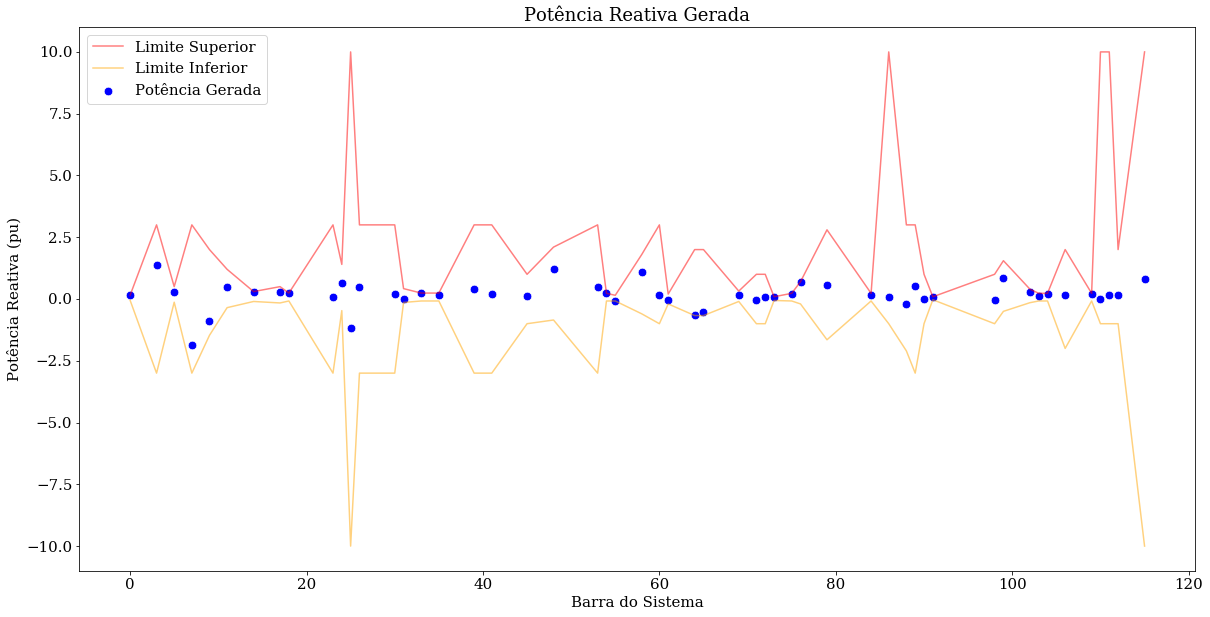

In [77]:
coleta_dados_gen(sep14)

In [199]:
pp.runpp(sep14,init='results',algorithm='nr',trafo_model='pi',tolerance_mva=1e-7)

In [125]:
sep14.trafo

,df,hv_bus,i0_percent,in_service,lv_bus,max_loading_percent,name,parallel,pfe_kw,shift_degree,...,tap_min,tap_phase_shifter,tap_pos,tap_side,tap_step_degree,tap_step_percent,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent
0,1.0,7,0.000000,True,4,100.0,None,1,0.0,0.0,...,NaN,False,-1.235735,hv,NaN,1.5,345.0,138.0,264.330000,0.000
1,1.0,25,0.000000,True,24,100.0,None,1,0.0,0.0,...,NaN,False,1.527142,hv,NaN,4.0,345.0,138.0,378.180000,0.000
2,1.0,29,0.000000,True,16,100.0,None,1,0.0,0.0,...,NaN,False,-0.411369,hv,NaN,4.0,345.0,138.0,384.120000,0.000
3,1.0,37,0.000000,True,36,100.0,None,1,0.0,0.0,...,NaN,False,-0.278013,hv,NaN,6.5,345.0,138.0,371.250000,0.000
4,1.0,62,0.000000,True,58,100.0,None,1,0.0,0.0,...,NaN,False,-0.490870,hv,NaN,4.0,345.0,138.0,382.140000,0.000
5,1.0,63,0.000000,True,60,100.0,None,1,0.0,0.0,...,NaN,False,0.065988,hv,NaN,1.5,345.0,138.0,265.320000,0.000
6,1.0,64,0.000000,True,65,100.0,None,1,0.0,0.0,...,NaN,False,-0.179909,hv,NaN,6.5,345.0,138.0,366.300000,0.000
7,1.0,64,-0.644444,True,67,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,345.0,161.0,158.988082,13.662
8,1.0,67,0.000000,True,68,100.0,None,1,0.0,0.0,...,NaN,False,-0.784785,hv,NaN,6.5,161.0,138.0,366.300000,0.000
9,1.0,80,-0.816162,True,67,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,345.0,161.0,200.729061,17.325


In [144]:
np.round(1.1712679*100,4)

117.1268

In [192]:
gbest

array([ 1.01762069e+00,  1.04905235e+00,  1.04160496e+00,  1.03350330e+00,
        1.04465352e+00,  1.03868486e+00,  1.03726144e+00,  1.03968597e+00,
        1.03582987e+00,  1.04213054e+00,  1.05000000e+00,  1.05000000e+00,
        1.03542068e+00,  1.03104086e+00,  1.03392350e+00,  1.04699151e+00,
        1.04508070e+00,  1.02569713e+00,  1.02755098e+00,  1.03678607e+00,
        1.04999992e+00,  1.02908519e+00,  1.02798373e+00,  1.02802585e+00,
        1.05000000e+00,  1.05000000e+00,  1.04593038e+00,  1.05000000e+00,
        1.05000000e+00,  1.02792197e+00,  1.03206539e+00,  1.02747881e+00,
        1.00965479e+00,  9.93746034e-01,  1.03571374e+00,  1.05000000e+00,
        1.04249679e+00,  1.04999999e+00,  1.05000000e+00,  1.03335177e+00,
        1.03794498e+00,  1.03894828e+00,  1.04511053e+00,  1.05000000e+00,
        1.04182608e+00,  1.03177951e+00,  1.02945231e+00,  1.01628910e+00,
        1.02594940e+00,  1.03394629e+00,  1.01022891e+00,  1.04676054e+00,
        1.04971064e+00,  

In [197]:
sep14.shunt

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,4,None,0.000232,0.0,138.0,1,1,True
1,33,None,-11.073449,0.0,138.0,1,1,True
2,36,None,-19.999994,0.0,138.0,1,1,True
3,43,None,-19.116100,0.0,138.0,1,1,True
4,44,None,-9.946098,0.0,138.0,1,1,True
5,45,None,-15.923164,0.0,138.0,1,1,True
6,47,None,7.164961,0.0,138.0,1,1,True
7,73,None,-9.815624,0.0,138.0,1,1,True
8,78,None,-9.999984,0.0,138.0,1,1,True
9,81,None,-5.029030,0.0,138.0,1,1,True


In [51]:
gbest

array([ 1.01762069e+00,  1.04905235e+00,  1.04160496e+00,  1.03350330e+00,
        1.04465352e+00,  1.03868486e+00,  1.03726144e+00,  1.03968597e+00,
        1.03582987e+00,  1.04213054e+00,  1.05000000e+00,  1.05000000e+00,
        1.03542068e+00,  1.03104086e+00,  1.03392350e+00,  1.04699151e+00,
        1.04508070e+00,  1.02569713e+00,  1.02755098e+00,  1.03678607e+00,
        1.04999992e+00,  1.02908519e+00,  1.02798373e+00,  1.02802585e+00,
        1.05000000e+00,  1.05000000e+00,  1.04593038e+00,  1.05000000e+00,
        1.05000000e+00,  1.02792197e+00,  1.03206539e+00,  1.02747881e+00,
        1.00965479e+00,  9.93746034e-01,  1.03571374e+00,  1.05000000e+00,
        1.04249679e+00,  1.04999999e+00,  1.05000000e+00,  1.03335177e+00,
        1.03794498e+00,  1.03894828e+00,  1.04511053e+00,  1.05000000e+00,
        1.04182608e+00,  1.03177951e+00,  1.02945231e+00,  1.01628910e+00,
        1.02594940e+00,  1.03394629e+00,  1.01022891e+00,  1.04676054e+00,
        1.04971064e+00,  

In [52]:
s

array([-2.31789176e-06,  1.10734486e-01,  1.99999940e-01,  1.91160999e-01,
        9.94609788e-02,  1.59231641e-01, -7.16496134e-02,  9.81562407e-02,
        9.99998364e-02,  5.02902962e-02,  7.90620157e-02,  1.99999975e-01,
        1.99999960e-01,  1.99999963e-01])

In [133]:
(cria_enxame(sep14,50))[:,len(tensao)+len(t):]

array([[ 0.  ,  0.06, -0.25,  0.1 ,  0.1 ,  0.1 ,  0.15,  0.2 ,  0.2 ,
         0.2 ,  0.2 ,  0.2 ,  0.  ,  0.14,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [-0.4 ,  0.06, -0.25,  0.  ,  0.1 ,  0.1 ,  0.15,  0.12,  0.  ,
         0.2 ,  0.1 ,  0.2 ,  0.06,  0.06,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [-0.4 ,  0.  , -0.25,  0.  ,  0.1 ,  0.1 ,  0.15,  0.12,  0.2 ,
         0.2 ,  0.  ,  0.1 ,  0.  ,  0.07,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [-0.4 ,  0.  , -0.25,  0.1 ,  0.1 ,  0.  ,  0.15,  0.2 ,  0.1 ,
         0.  ,  0.1 ,  0.2 ,  0.07,  0.06,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [ 0.  ,  0.06, -0.25,  0.1 ,  0.  ,  0.  ,  0.15,  0.08,  0.  ,
         0.  ,  0.2 ,  0.2 ,  0.07,  0.13,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [-0.4 ,  0.14, -0.25,  0.  ,  0.  ,  0.1 ,  0.  ,  0.2 ,  0.1 ,
         0.  ,  0.1 ,  0.2 ,  0.2 ,  0.13,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ],
       [ 0

In [136]:
fluxo_de_pot(cria_enxame(sep14,1),sep14)

array([[ 1.05467235e+00,  1.05949855e+00,  1.05025120e+00,
         1.05484584e+00,  1.05709316e+00,  1.05311896e+00,
         1.05542225e+00,  1.05104154e+00,  1.05526378e+00,
         1.05076768e+00,  1.05148829e+00,  1.05908792e+00,
         1.05515944e+00,  1.05169352e+00,  1.05640258e+00,
         1.05321823e+00,  1.05671299e+00,  1.05994537e+00,
         1.05615047e+00,  1.05051326e+00,  1.05123731e+00,
         1.05671149e+00,  1.05972256e+00,  1.05640075e+00,
         1.05093539e+00,  1.05971376e+00,  1.05048309e+00,
         1.05036445e+00,  1.05916335e+00,  1.05230768e+00,
         1.05123754e+00,  1.05525766e+00,  1.05392079e+00,
         1.05270614e+00,  1.05543046e+00,  1.05115105e+00,
         1.05562975e+00,  1.05115178e+00,  1.05242391e+00,
         1.05347692e+00,  1.05459110e+00,  1.05518916e+00,
         1.05859612e+00,  1.05642994e+00,  1.05222137e+00,
         1.05709616e+00,  1.05835592e+00,  1.05934444e+00,
         1.05185826e+00,  1.05206267e+00,  1.05997384e+0

In [7]:
a = cria_enxame(sep14,10)

In [8]:
fluxo_de_pot(sep14,a)

AttributeError: 'numpy.ndarray' object has no attribute 'shunt'

In [6]:
sep14.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,1,True,True,None,40.0,1.0,NaN,None,1.045,False,140.0,0.0,50.0,-40.0
1,2,True,True,None,0.0,1.0,NaN,None,1.010,False,100.0,0.0,40.0,0.0
2,5,True,True,None,0.0,1.0,NaN,None,1.070,False,100.0,0.0,24.0,-6.0
3,7,True,True,None,0.0,1.0,NaN,None,1.090,False,100.0,0.0,24.0,-6.0


In [12]:
sep14.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,1,True,True,None,40.0,1.0,NaN,None,0.970530,False,140.0,0.0,50.0,-40.0
1,2,True,True,None,0.0,1.0,NaN,None,0.989309,False,100.0,0.0,40.0,0.0
2,5,True,True,None,0.0,1.0,NaN,None,0.974489,False,100.0,0.0,24.0,-6.0
3,7,True,True,None,0.0,1.0,NaN,None,1.075000,False,100.0,0.0,24.0,-6.0


In [102]:
teste = []

for i in range(1000):
    
    teste.append(np.random.randn()/3)

(array([ 2.,  1.,  1.,  0.,  6.,  3.,  8., 10.,  7., 14., 11., 25., 15.,
        24., 23., 33., 34., 37., 41., 45., 52., 46., 44., 40., 64., 42.,
        49., 39., 47., 41., 30., 31., 25., 25., 19., 15., 16.,  8.,  9.,
         2.,  6.,  4.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([-0.95853759, -0.91753457, -0.87653156, -0.83552855, -0.79452553,
        -0.75352252, -0.71251951, -0.67151649, -0.63051348, -0.58951047,
        -0.54850745, -0.50750444, -0.46650143, -0.42549841, -0.3844954 ,
        -0.34349239, -0.30248937, -0.26148636, -0.22048335, -0.17948033,
        -0.13847732, -0.09747431, -0.05647129, -0.01546828,  0.02553473,
         0.06653775,  0.10754076,  0.14854378,  0.18954679,  0.2305498 ,
         0.27155282,  0.31255583,  0.35355884,  0.39456186,  0.43556487,
         0.47656788,  0.5175709 ,  0.55857391,  0.59957692,  0.64057994,
         0.68158295,  0.72258596,  0.76358898,  0.80459199,  0.845595  ,
         0.88659802,  0.92760103,  0.96860404,  1.00960706,

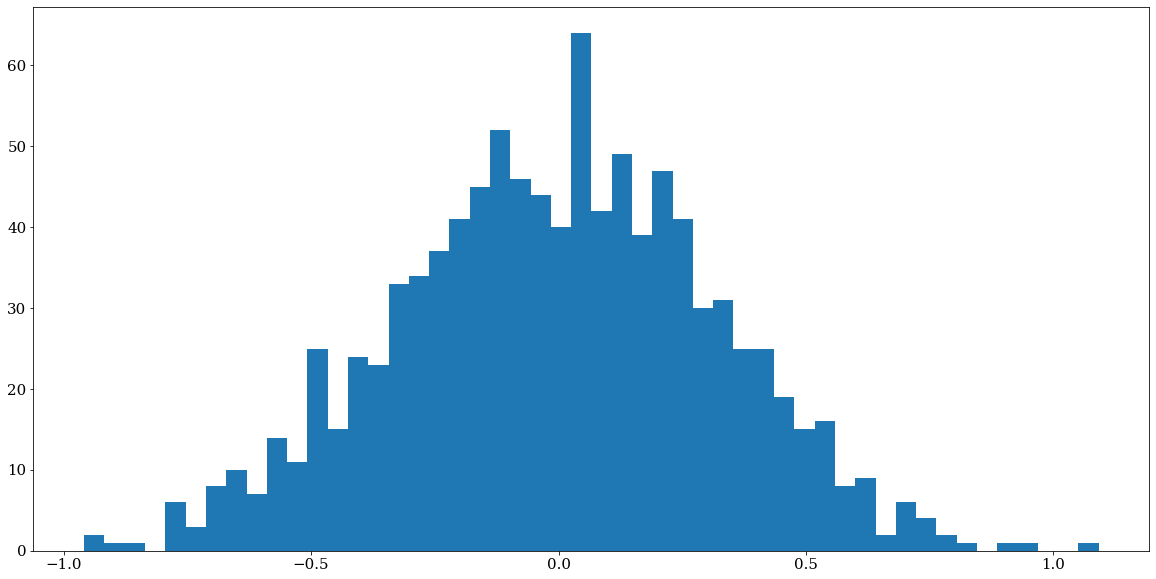

In [103]:
plt.hist(teste,bins=50)

In [252]:
ala = cria_enxame(sep14,2)
linha=0

In [256]:
ala[linha,0:len(sep14.gen)+1] = ala[linha,0:len(sep14.gen)+1] + (1.05-0.95) * (np.random.randn(len(sep14.gen)+1)/3)*1

ala[linha,0:len(sep14.gen)+1][
ala[linha,0:len(sep14.gen)+1]>1.05] = 1.05

ala[linha,0:len(sep14.gen)+1][
ala[linha,0:len(sep14.gen)+1]<0.95] = 0.95

ala[linha,len(sep14.gen)+1:len(sep14.gen)+1+len(t)] = ala[linha,len(sep14.gen)+1:len(sep14.gen)+1+len(t)] + (1.12-0.88) * (np.random.randn(len(t))/3 )*1


ala[linha,len(sep14.gen)+1:len(sep14.gen)+1+len(t)][
ala[linha,len(sep14.gen)+1:len(sep14.gen)+1+len(t)]<0.88] = 0.88

ala[linha,len(sep14.gen)+1:len(sep14.gen)+1+len(t)][
ala[linha,len(sep14.gen)+1:len(sep14.gen)+1+len(t)]>1.12] = 1.12

ala[linha,len(tensao):len(t)+len(tensao)] = discreto_tap(ala[linha,:],len(t),len(tensao),len(s),sep14)


In [257]:
ala

array([[ 1.05      ,  1.05      ,  1.05      ,  1.05      ,  1.00305707,
         1.05      ,  0.99332183,  1.05      ,  1.05      ,  1.03534597,
         1.00442036,  1.03691935,  1.04835485,  1.05      ,  1.0176521 ,
         0.95      ,  0.9654453 ,  1.05      ,  1.05      ,  1.02780328,
         0.99931511,  0.95      ,  1.05      ,  1.02858283,  1.01147299,
         1.05      ,  1.05      ,  1.04946903,  1.03305835,  1.05      ,
         1.00247068,  1.04220956,  1.00658891,  1.05      ,  1.0004964 ,
         0.95      ,  1.0336168 ,  1.00425984,  0.95      ,  1.05      ,
         1.02022268,  1.03559595,  1.01005783,  1.05      ,  1.0426261 ,
         0.98925741,  1.01841947,  1.03935367,  1.05      ,  1.04069765,
         1.05      ,  1.01414772,  1.05      ,  1.03683247,  1.0225    ,
         1.075     ,  0.88      ,  0.9475    ,  0.8875    ,  0.88      ,
         0.88      ,  1.1125    ,  1.0225    ,  0.        ,  0.14      ,
        -0.25      ,  0.1       ,  0.        ,  0.1

In [249]:
ala

array([0.97275878, 1.05      , 1.05      , 1.05      , 1.00245662,
       0.95      , 1.02040038, 0.95358137, 1.05      , 0.98996871,
       1.05      , 0.95      , 1.00474515, 1.04880506, 0.97652981,
       0.95      , 1.03741934, 1.04262889, 0.97249419, 1.01056902,
       0.98158481, 1.02992952, 1.00426744, 1.03205881, 0.95      ,
       1.02746445, 1.02097425, 1.02127972, 0.99532815, 1.05      ,
       0.95294006, 0.95      , 1.05      , 0.95      , 0.99543607,
       1.05      , 0.96260426, 0.98391994, 1.05      , 0.97668279,
       1.0461751 , 1.04111985, 1.02231969, 1.05      , 0.97443521,
       1.02183207, 1.00570495, 1.05      , 1.03437207, 0.95      ,
       1.02777165, 1.04227785, 1.05      , 1.03557285, 0.88      ,
       0.97      , 0.97      , 1.0675    , 1.0825    , 0.8875    ,
       0.955     , 0.9325    , 1.0525    , 0.        , 0.14      ,
       0.        , 0.1       , 0.1       , 0.1       , 0.        ,
       0.12      , 0.1       , 0.2       , 0.2       , 0.2    

In [250]:
gbest

array([1.05      , 1.01647523, 1.04692119, 1.03966342, 1.03000502,
       1.04827057, 1.03694739, 1.03630965, 1.03857113, 1.03490873,
       1.04178236, 1.05      , 1.05      , 1.03470878, 1.03021693,
       1.03319132, 1.04699339, 1.04507963, 1.02572499, 1.02757548,
       1.03687452, 1.05      , 1.02908422, 1.02797331, 1.02802128,
       1.05      , 1.05      , 1.04604282, 1.05      , 1.05      ,
       1.02688877, 1.03187957, 1.02757932, 1.00450028, 0.99125371,
       1.03421961, 1.05      , 1.04225773, 1.04999998, 1.05      ,
       1.03334942, 1.03793956, 1.03891536, 1.04511071, 1.05      ,
       1.04182611, 1.03178054, 1.02945376, 1.01628913, 1.02594962,
       1.03394651, 1.01022913, 1.04576139, 1.04883898, 0.98146632,
       1.06108577, 0.98355485, 0.98196349, 0.9804092 , 1.00107703,
       0.98830706, 0.94931845, 0.98758128, 0.        , 0.14      ,
       0.        , 0.1       , 0.1       , 0.1       , 0.        ,
       0.12      , 0.1       , 0.2       , 0.2       , 0.2    

In [52]:
sep14.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,0,True,True,None,0.0,1.0,NaN,None,1.017621,False,100.0,0.0,15.0,-5.0
1,3,True,True,None,0.0,1.0,NaN,None,1.049052,False,100.0,0.0,300.0,-300.0
2,5,True,True,None,0.0,1.0,NaN,None,1.041605,False,100.0,0.0,50.0,-13.0
3,7,True,True,None,0.0,1.0,NaN,None,1.033503,False,100.0,0.0,300.0,-300.0
4,9,True,True,None,450.0,1.0,NaN,None,1.044654,False,550.0,0.0,200.0,-147.0
5,11,True,True,None,85.0,1.0,NaN,None,1.038685,False,185.0,0.0,120.0,-35.0
6,14,True,True,None,0.0,1.0,NaN,None,1.037261,False,100.0,0.0,30.0,-10.0
7,17,True,True,None,0.0,1.0,NaN,None,1.039686,False,100.0,0.0,50.0,-16.0
8,18,True,True,None,0.0,1.0,NaN,None,1.035830,False,100.0,0.0,24.0,-8.0
9,23,True,True,None,0.0,1.0,NaN,None,1.042131,False,100.0,0.0,300.0,-300.0


In [45]:
validacao(sep14,gbest)

Perdas de Potência Ativa [PU]:

1.1492521130261928
 
Penalização de Violação de Tensão [PU]:

1.0837854701515752e-06
 
Penalização de Violação de Geração de Reativo [PU]:

0.07792841662590913
 
Penalização de Violação de TAP Discreto [PU]:

6.749999999997828
 
Penalização de Violação de Bshunt Discreto [PU]:

1.5481556010383346e-27
 


In [49]:
s-gbest[-6-len(s):-6]

array([-1.18909684e-07, -2.25140240e-02,  2.00000000e-01,  8.62043829e-02,
        1.89710860e-04,  5.63509979e-02, -1.07948447e-01,  1.34854936e-02,
        0.00000000e+00,  4.99330937e-02, -2.31522140e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [50]:
gbest[-6-len(s):-6]

array([0.  , 0.13, 0.  , 0.1 , 0.1 , 0.1 , 0.  , 0.08, 0.1 , 0.  , 0.1 ,
       0.2 , 0.2 , 0.2 ])

In [51]:
s

array([-1.18909684e-07,  1.07485976e-01,  2.00000000e-01,  1.86204383e-01,
        1.00189711e-01,  1.56350998e-01, -1.07948447e-01,  9.34854936e-02,
        1.00000000e-01,  4.99330937e-02,  7.68477860e-02,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01])

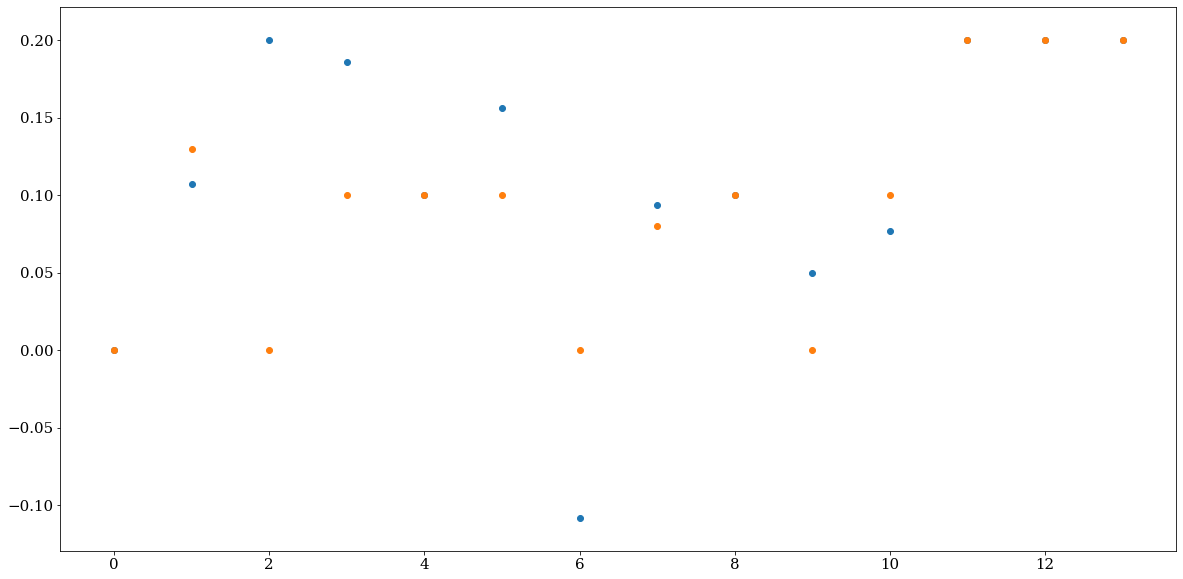

In [53]:
plt.scatter(np.arange(0,len(s),1),s)
plt.scatter(np.arange(0,len(s),1),gbest[-6-len(s):-6])

In [54]:
coleta_dados_bshunt(sep14)

(array([list([-0.4, 0]), list([0, 0.06, 0.07, 0.13, 0.14, 0.2]),
        list([-0.25, 0]), list([0, 0.1]), list([0, 0.1]), list([0, 0.1]),
        list([0, 0.15]), list([0.08, 0.12, 0.2]), list([0, 0.1, 0.2]),
        list([0, 0.1, 0.2]), list([0, 0.1, 0.2]), list([0, 0.1, 0.2]),
        list([0, 0.06, 0.07, 0.13, 0.14, 0.2]),
        list([0, 0.06, 0.07, 0.13, 0.14, 0.2])], dtype=object),
 array([  4,  33,  36,  43,  44,  45,  47,  73,  78,  81,  82, 104, 106,
        109], dtype=uint32))

In [55]:
sep14.load

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,4,None,-0.0,0.0,138.0,1,1,True
1,33,None,-13.0,0.0,138.0,1,1,True
2,36,None,-0.0,0.0,138.0,1,1,True
3,43,None,-10.0,0.0,138.0,1,1,True
4,44,None,-10.0,0.0,138.0,1,1,True
5,45,None,-10.0,0.0,138.0,1,1,True
6,47,None,-0.0,0.0,138.0,1,1,True
7,73,None,-8.0,0.0,138.0,1,1,True
8,78,None,-10.0,0.0,138.0,1,1,True
9,81,None,-0.0,0.0,138.0,1,1,True
